# Milvus 기반 텍스트 임베딩 저장
> 🔥 Goal
>
>    1. KLUE/RoBERTa를 기반으로 Text Data를 Embedding으로 변환
>
>    2. Milvus에 임베딩 데이터 저장

## 0. Import Library

### Install Milvus
- python virtual env; activate milenv 
    - Jupyter에서 인식될 수 있도록 ipykernel 설치
- [Milvus 2.5](https://milvus.io/docs/ko/install_standalone-docker-compose.md)

🐳 Docker Compose 구성 파일 다운로드

!wget https://github.com/milvus-io/milvus/releases/download/v2.5.5/milvus-standalone-docker-compose.yml -O docker-compose.yml


🐳 Milvus Container 실행

!sudo docker compose up -d

✔️ Install PyMilvus 

pip install "pymilvus[model]" -U 

### Retriever Definition

정보 검색을 위해 정의

In [ ]:
import json

from pymilvus import (
    MilvusClient,
    DataType,
    Function,
    FunctionType,
    AnnSearchRequest,
    RRFRanker,
)

from pymilvus.model.hybrid import BGEM3EmbeddingFunction


class HybridRetriever:
    def __init__(self, uri, collection_name="hybrid", dense_embedding_function=None):
        self.uri = uri
        self.collection_name = collection_name
        self.embedding_function = dense_embedding_function
        self.use_reranker = True
        self.use_sparse = True
        self.client = MilvusClient(uri=uri) # 데이터베이스 연결

    def build_collection(self):
        if isinstance(self.embedding_function.dim, dict):
            dense_dim = self.embedding_function.dim["dense"]
        else:
            dense_dim = self.embedding_function.dim

        # 토크나이저 설정
        tokenizer_params = {
            "tokenizer": "standard",
            "filter": [
                "lowercase",
                {
                    "type": "length",
                    "max": 200,
                },
                {"type": "stemmer", "language": "english"},
                {
                    "type": "stop",
                    "stop_words": [
                        "a",
                        "an",
                        "and",
                        "are",
                        "as",
                        "at",
                        "be",
                        "but",
                        "by",
                        "for",
                        "if",
                        "in",
                        "into",
                        "is",
                        "it",
                        "no",
                        "not",
                        "of",
                        "on",
                        "or",
                        "such",
                        "that",
                        "the",
                        "their",
                        "then",
                        "there",
                        "these",
                        "they",
                        "this",
                        "to",
                        "was",
                        "will",
                        "with",
                    ],
                },
            ],
        }
        
        # Milvus 컬렉션 스키마 생성
        schema = MilvusClient.create_schema()
        schema.add_field(
            field_name="pk",
            datatype=DataType.VARCHAR,
            is_primary=True,
            auto_id=True,
            max_length=100,
        )
        schema.add_field(
            field_name="content",
            datatype=DataType.VARCHAR,
            max_length=65535,
            analyzer_params=tokenizer_params,
            enable_match=True,
            enable_analyzer=True,
        )
        schema.add_field(
            field_name="sparse_vector", datatype=DataType.SPARSE_FLOAT_VECTOR
        )
        schema.add_field(
            field_name="dense_vector", datatype=DataType.FLOAT_VECTOR, dim=dense_dim
        )
        schema.add_field(
            field_name="original_uuid", datatype=DataType.VARCHAR, max_length=128
        )
        schema.add_field(field_name="doc_id", datatype=DataType.VARCHAR, max_length=64)
        schema.add_field(
            field_name="chunk_id", datatype=DataType.VARCHAR, max_length=64
        ),
        schema.add_field(field_name="original_index", datatype=DataType.INT32)

        # 스코어 저장
        functions = Function(
            name="bm25",
            function_type=FunctionType.BM25,
            input_field_names=["content"],
            output_field_names="sparse_vector",
        )

        schema.add_function(functions)

        index_params = MilvusClient.prepare_index_params()
        index_params.add_index(
            field_name="sparse_vector",
            index_type="SPARSE_INVERTED_INDEX",
            metric_type="BM25",
        )
        index_params.add_index(
            field_name="dense_vector", index_type="FLAT", metric_type="IP"
        )

        self.client.create_collection(
            collection_name=self.collection_name,
            schema=schema,
            index_params=index_params,
        )

    # 데이터 삽입
    def insert_data(self, chunk, metadata):
        embedding = self.embedding_function([chunk])
        if isinstance(embedding, dict) and "dense" in embedding:
            dense_vec = embedding["dense"][0]
        else:
            dense_vec = embedding[0]
        self.client.insert(
            self.collection_name, {"dense_vector": dense_vec, **metadata}
        )

    # 검색 기능
    def search(self, query: str, k: int = 20, mode="hybrid"):

        output_fields = [
            "content",
            "original_uuid",
            "doc_id",
            "chunk_id",
            "original_index",
        ]
        if mode in ["dense", "hybrid"]:
            embedding = self.embedding_function([query])
            if isinstance(embedding, dict) and "dense" in embedding:
                dense_vec = embedding["dense"][0]
            else:
                dense_vec = embedding[0]

        if mode == "sparse":
            results = self.client.search(
                collection_name=self.collection_name,
                data=[query],
                anns_field="sparse_vector",
                limit=k,
                output_fields=output_fields,
            )
        elif mode == "dense":
            results = self.client.search(
                collection_name=self.collection_name,
                data=[dense_vec],
                anns_field="dense_vector",
                limit=k,
                output_fields=output_fields,
            )
        elif mode == "hybrid":
            full_text_search_params = {"metric_type": "BM25"}
            full_text_search_req = AnnSearchRequest(
                [query], "sparse_vector", full_text_search_params, limit=k
            )

            dense_search_params = {"metric_type": "IP"}
            dense_req = AnnSearchRequest(
                [dense_vec], "dense_vector", dense_search_params, limit=k
            )

            results = self.client.hybrid_search(
                self.collection_name,
                [full_text_search_req, dense_req],
                ranker=RRFRanker(),
                limit=k,
                output_fields=output_fields,
            )
        else:
            raise ValueError("Invalid mode")
        return [
            {
                "doc_id": doc["entity"]["doc_id"],
                "chunk_id": doc["entity"]["chunk_id"],
                "content": doc["entity"]["content"],
                "score": doc["distance"],
            }
            for doc in results[0]
        ]

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


Milvus 기반 하이브리드 검색 시스템
- BM25 기반 sparse vector 검색
- DL 기반 임베딩 검색


### Others

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 1. Test Embedding Vector 

법률 데이터 업로드 없이 Milvus만 테스트
- 저장된 데이터 검색 및 조회

### Load Embedding Model

In [9]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

MODEL_NAME = "klue/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)
model = AutoModel.from_pretrained(MODEL_NAME).to(device)

def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device) 
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()  
    return embedding

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Collect Data in Milvus 

- [create index](https://milvus.io/api-reference/pymilvus/v2.3.x/MilvusClient/Management/create_index.md)

In [ ]:
from pymilvus import MilvusClient, DataType

client = MilvusClient(uri="http://localhost:19530")

collection_name = "klue_roberta_embeddings"

# 컬랙션 생성
schema = MilvusClient.create_schema()
schema.add_field("id", DataType.INT64, is_primary=True, auto_id=True)
schema.add_field("content", DataType.VARCHAR, max_length=1024)  # 원본 텍스트 저장
schema.add_field("vector", DataType.FLOAT_VECTOR, dim=768)  # KLUE/RoBERTa 임베딩 저장

client.create_collection(collection_name=collection_name, schema=schema)

# 벡터 필드에 대한 인덱스 생성
index_params = client.prepare_index_params()
index_params.add_index(
    field_name="vector",
    index_type="IVF_FLAT",
    metric_type="L2",
    params={"nlist": 128}
)
client.create_index(collection_name, index_params)

### Add Data

In [26]:
data = [
    "한국의 인공지능 연구는 빠르게 발전하고 있습니다.",
    "Milvus는 벡터 데이터베이스입니다.",
    "로봇 공학과 딥러닝은 밀접한 관련이 있습니다."
]

# 데이터 변환 및 Milvus 삽입
for text in data:
    embedding = get_embedding(text) 
    client.insert(collection_name, [{"content": text, "vector": embedding.tolist()}])

### Search

In [27]:
# Milvus에 저장된 모든 컬렉션 확인
print(client.list_collections())  

['klue_roberta_embeddings']


In [28]:
# Vector DB 검색 수행을 위해 인덱스 생성 유무 파악
print(client.describe_collection(collection_name))
print(client.list_indexes(collection_name))

{'collection_name': 'klue_roberta_embeddings', 'auto_id': True, 'num_shards': 1, 'description': '', 'fields': [{'field_id': 100, 'name': 'id', 'description': '', 'type': <DataType.INT64: 5>, 'params': {}, 'auto_id': True, 'is_primary': True}, {'field_id': 101, 'name': 'content', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 1024}}, {'field_id': 102, 'name': 'vector', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 768}}], 'functions': [], 'aliases': [], 'collection_id': 456592164736288327, 'consistency_level': 2, 'properties': {}, 'num_partitions': 1, 'enable_dynamic_field': False, 'created_timestamp': 456610227358269446}
['vector']


In [29]:
# 컬렉션 로드
client.load_collection(collection_name)

query = "AI 연구가 빠르게 진행 중이다."
query_vector = get_embedding(query) 

# Milvus에서 검색
results = client.search(
    collection_name=collection_name,
    data=[query_vector],
    anns_field="vector",
    limit=3, 
    output_fields=["content"]
)

# 검색 결과 출력
for doc in results[0]:
    print(f"📌 {doc['entity']['content']} (유사도: {doc['distance']})")

📌 한국의 인공지능 연구는 빠르게 발전하고 있습니다. (유사도: 1.2914175987243652)
📌 한국의 인공지능 연구는 빠르게 발전하고 있습니다. (유사도: 1.2914175987243652)
📌 로봇 공학과 딥러닝은 밀접한 관련이 있습니다. (유사도: 1.7175631523132324)


## 2. Streamlit Dashboard 최적화 
- upload dataframe 

### Load Data

In [1]:
import pandas as pd

train = pd.read_csv("../exploration/dataset_law/data/train_data.csv")
valid = pd.read_csv("../exploration/dataset_law/data/val_data.csv")

In [ ]:
from datasets import load_dataset
data_cn = load_dataset("lbox/lbox_open", "casename_classification", download_mode="force_redownload")
test_data = data_cn['test']

test = pd.DataFrame(test_data)
test = test[['casetype', 'facts']]

test.rename(columns={'casetype': 'class', 'facts': 'text'}, inplace=True)

0000.parquet:   0%|          | 0.00/5.66M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/739k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/743k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/890k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test2 split:   0%|          | 0/1294 [00:00<?, ? examples/s]

,class,text
0,criminal,"질병관리청장, 시·도지사 또는 시장·군수·구청장은 감염병이 유행하면 감염병의 전파를..."
1,criminal,"질병관리청장, 시․도지사 또는 시장․군수․구청장은 감염병을 예방하기 위하여 감염병의..."
2,criminal,보건복지부장관은 2020. 1. 8.경 코로나바이러스감염증-19(이하 ‘코로나-19...
3,criminal,"질병관리청장, 시·도지사 또는 시장·군수·구청장은 감염병을 예방하기 위하여 흥행, ..."
4,criminal,"피고인들은 수원시 영통구 C, D호에서 E 유흥주점을 공동으로 운영하는 사람들이다...."
...,...,...
995,criminal,피고인은 2019. 5.경 청주시 흥덕구 B에 있는 피해자 C이 운영하는 'D' 주...
996,criminal,"피고인은 2019. 1. 12.경 전남 목포시 B, 2층 C직업소개소에서 2019...."
997,criminal,피고인은 2018. 4. 24.경부터 2018. 7. 9.까지 당진시 B에 있는 C...
998,criminal,범죄전력\n피고인은 2019. 9. 6. 수원지방법원 평택지원에서 횡령죄로 징역 8...


#### 벡터 DB 저장을 위한 커스텀 데이터셋
PyTorch DataLoader를 활용

In [6]:
from torch.utils.data import Dataset, DataLoader
from pymilvus import MilvusClient, DataType

class MilvusDataset(Dataset):
    def __init__(self, dataframe, set_type):
        self.data = dataframe
        self.set_type = set_type
        self.column_name = 'text' if 'text' in dataframe.columns else 'facts'
        self.texts = self.data[self.column_name]
        self.labels = self.data['class'] 

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts.iloc[idx], self.labels.iloc[idx]

In [7]:
# Train/Valid/Test 데이터셋 로드
train_dataset = MilvusDataset(train, "train")
valid_dataset = MilvusDataset(valid, "valid")
test_dataset = MilvusDataset(test, "test")

In [8]:
# PyTorch DataLoader 사용하여 배치 처리
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Load Model & Tokenizer 

In [14]:
from transformers import AutoTokenizer, AutoModel
import torch

# KLUE RoBERTa 모델 & 토크나이저 로드
MODEL_NAME = "klue/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to("cuda")  # GPU 사용

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# 배치 단위로 Text Embedding
def get_embedding(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()

### Load Milvus

In [18]:
from pymilvus import MilvusClient, DataType

# Milvus 연결
client = MilvusClient(uri="http://localhost:19530")
collection_name = "embedding_store"

# Milvus 스키마 정의
schema = MilvusClient.create_schema()
schema.add_field("id", DataType.INT64, is_primary=True, auto_id=True)
schema.add_field("set_type", DataType.VARCHAR, max_length=10)  # "train", "valid", "test"
schema.add_field("class", DataType.VARCHAR, max_length=50)  # "criminal", "political" 등
schema.add_field("vector", DataType.FLOAT_VECTOR, dim=768)  # RoBERTa 768차원 벡터

# 컬렉션 생성
client.create_collection(collection_name=collection_name, schema=schema)

### Milvus에 Vector 저장

DataLoader를 이용하여 배치 단위로 벡터 변환 후 Milvus에 저장

In [19]:
def insert_embeddings(loader, set_type):
    for batch_texts, batch_labels in loader:
        embeddings = get_embedding(batch_texts)  # KLUE/RoBERTa 임베딩 변환
        insert_data = [
            {"set_type": set_type, "class": batch_labels[i], "vector": embeddings[i].tolist()}
            for i in range(len(batch_texts))
        ]
        client.insert(collection_name, insert_data)

In [20]:
# Milvus에 Train/Valid/Test 데이터 저장
insert_embeddings(train_loader, "train")
insert_embeddings(valid_loader, "valid")
insert_embeddings(test_loader, "test")

### 벡터 가져오기

In [22]:
# Milvus에서 벡터를 불러오기 위한 Dataset
class MilvusVectorDataset(Dataset):
    def __init__(self, set_type):
        self.set_type = set_type
        self.vectors = self.load_vectors()

    def load_vectors(self):
        results = client.query(
            collection_name=collection_name,
            filter=f"set_type == '{self.set_type}'",
            output_fields=["vector"]
        )
        return [res["vector"] for res in results]

    def __len__(self):
        return len(self.vectors)

    def __getitem__(self, idx):
        return self.vectors[idx]

In [23]:
# Train/Valid/Test 벡터 로딩
train_vector_dataset = MilvusVectorDataset("train")
valid_vector_dataset = MilvusVectorDataset("valid")
test_vector_dataset = MilvusVectorDataset("test")

# DataLoader 설정 (벡터 불러오기)
train_vector_loader = DataLoader(train_vector_dataset, batch_size=32, shuffle=False)
valid_vector_loader = DataLoader(valid_vector_dataset, batch_size=32, shuffle=False)
test_vector_loader = DataLoader(test_vector_dataset, batch_size=32, shuffle=False)

### Visualization

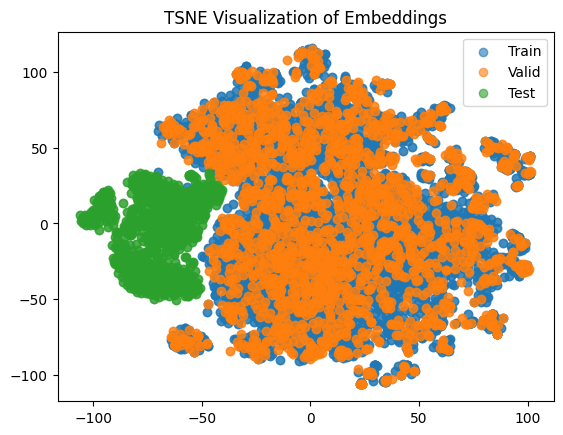

In [24]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# TSNE 차원 축소
tsne = TSNE(n_components=2, random_state=42)
all_vectors = np.vstack([train_vector_dataset.vectors, valid_vector_dataset.vectors, test_vector_dataset.vectors])
embedded_2d = tsne.fit_transform(all_vectors)

# 데이터셋별 구분
train_size = len(train_vector_dataset)
valid_size = len(valid_vector_dataset)

train_2d = embedded_2d[:train_size]
valid_2d = embedded_2d[train_size:train_size + valid_size]
test_2d = embedded_2d[train_size + valid_size:]

# 시각화
fig, ax = plt.subplots()
ax.scatter(train_2d[:, 0], train_2d[:, 1], label="Train", alpha=0.6)
ax.scatter(valid_2d[:, 0], valid_2d[:, 1], label="Valid", alpha=0.6)
ax.scatter(test_2d[:, 0], test_2d[:, 1], label="Test", alpha=0.6)

ax.legend()
plt.title("TSNE Visualization of Embeddings")
plt.show()
